<a href="https://colab.research.google.com/github/taritro98/MachineHack_HousePrices/blob/master/house_prices_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ppscore
!pip install catboost
!pip install sweetviz
!pip install bayesian_optimization
!pip install category_encoders

  Created wheel for ppscore: filename=ppscore-1.1.1-py2.py3-none-any.whl size=12987 sha256=b475064581b7381e7174e7c359ec1fe7d3f885025b135a28843df8e19081daef
  Stored in directory: /root/.cache/pip/wheels/3a/16/cb/4768ae3fd9f02af8cd6d880b9095281cc62bb1748fac67fdc4
Successfully built ppscore
     |████████████████████████████████| 66.2MB 56kB/s 
     |████████████████████████████████| 15.1MB 312kB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=435de0773f3b866b381fdea2164dbd0ea33ad937aa57bf0b2a9ccc8d4983d241
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
     |████████████████████████████████| 81kB 2.2MB/s 


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import ppscore as pps

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

import warnings
warnings.simplefilter('ignore')
#%load_ext google.colab.data_table

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [3]:
%cd drive/My\ Drive/house_prices

/content/drive/My Drive/house_prices


In [4]:
ss = pd.read_csv('input/sample_submission.csv')
train = pd.read_csv('input/Train.csv')
test = pd.read_csv('input/Test.csv')

In [5]:
train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


### Feature Engineering

In [65]:
t=pd.concat([train.drop('TARGET(PRICE_IN_LACS)', axis=1),test],ignore_index=True)
target = train['TARGET(PRICE_IN_LACS)']

In [66]:
t.SQUARE_FT = np.log1p(t.SQUARE_FT)
posted_one_hot = pd.get_dummies(t['POSTED_BY'])
t = pd.concat([posted_one_hot,t], axis=1)
t['BHK_Count'] = t.groupby('BHK_NO.')['BHK_NO.'].transform('count')
t['City'] = t['ADDRESS'].apply(lambda x: pd.Series(str(x).split(',')[1]))
t['Locality'] = t['ADDRESS'].apply(lambda x: pd.Series(str(x).split(',')[0]))
t['City'] = t['City'].str.lower()
t.City = t.City.str.strip()

In [67]:
city_list = t['City'].value_counts().index[:30].tolist()
for city in city_list:
    t.City[t.City.str.contains(city)] = city

In [68]:
t['City'][t['City'].str.contains('thane')] = 'mumbai'
t['City'][t['City'].str.contains('bandra')] = 'mumbai'
t['City'][t['City'].str.contains('andheri')] = 'mumbai'
t['City'][t['City'].str.contains('bengaluru')] = 'bangalore'
t['City'][t['City'].str.contains('kakkanad')] = 'kochi'
t['City'][t['City'].str.contains('ernakulam')] = 'kochi'
t['City'][t['City'].str.contains('madhapur')] = 'hyderabad'
t['City'][t['City'].str.contains('edappally')] = 'kochi'
t['City'][t['City'].str.contains('kaloor')] = 'kochi'
t['City'][t['City'].str.contains('delhi')] = 'new delhi'
t['City'][t['City'].str.contains('dwarka')] = 'new delhi'
t['City'][t['City'].str.contains('ncr')] = 'new delhi'
t['City'][t['City'].str.contains('telangana')] = 'hyderabad'
t['City'][t['City'].str.contains('jubilee hills')] = 'hyderabad'
t['City'][t['City'].str.contains('gurugram')] = 'gurgaon'
t['City'][t['City'] == 'banglore'] = 'bangalore'
t['City'][t['City'] == 'bengaluru'] = 'bangalore'
t['City'][t['City'] == 'bengalore'] = 'bangalore'
t['City'][t['City'] == 'dwarka'] = 'new delhi'
t['City'][t['City'] == 'delhi'] = 'new delhi'

In [69]:
t.loc[t["City"].isin(t['City'].value_counts()[t['City'].value_counts()<=100].index.tolist()),"City"] = "Other"

In [70]:
ce_hash = ce.HashingEncoder(cols=['City'])
hash_train_df = pd.DataFrame(ce_hash.fit_transform(t[0:train.shape[0]],target))
hash_test_df = pd.DataFrame(ce_hash.transform(t[train.shape[0]:]))

In [71]:
hash_df = pd.concat([hash_train_df.iloc[:,:8],hash_test_df.iloc[:,:8]])
hash_df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0


In [72]:
t = pd.concat([hash_df,t], axis=1)

In [162]:
city_freq_map = t.City.value_counts().to_dict()
locality_freq_map = t.Locality.value_counts().to_dict()

In [167]:
t['City_freq'] = t.City.map(city_freq_map)
t['Locality_freq'] = t.Locality.map(locality_freq_map)

In [164]:
t.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,BHK_Count,City,Locality,Tier,City_freq,Locliaty_freq
0,0,0,0,1,0,0,0,0,0,0,1,Owner,0,0,2,BHK,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,44322,bangalore,Other,2,14268,7886
1,0,0,0,1,0,0,0,0,0,1,0,Dealer,0,0,2,BHK,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,44322,mysore,vishweshwara nagar,1,183,18
2,0,0,0,1,0,0,0,0,0,0,1,Owner,0,0,2,BHK,6.839647,1,1,"Jigani,Bangalore",12.778033,77.632191,44322,bangalore,jigani,2,14268,41
3,0,0,0,0,1,0,0,0,0,0,1,Owner,0,1,2,BHK,6.836175,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,44322,ghaziabad,sector-1 vaishali,1,3602,44
4,0,0,0,0,0,0,1,0,0,1,0,Dealer,1,0,2,BHK,6.907765,0,1,"New Town,Kolkata",22.592200,88.484911,44322,kolkata,new town,2,5821,499


In [134]:
t['Locality'] = t['Locality'].str.lower()
t.Locality = t.Locality.str.strip()

In [135]:
t.Locality.fillna('Other', inplace=True)

In [137]:
t['Locality'] = t['Locality'].str.replace("west","")
t['Locality'] = t['Locality'].str.replace("east","")
t['Locality'] = t['Locality'].str.replace(r"\(.*\)","")

In [140]:
t['Locality'][t['Locality'].str.contains('noida')] = 'noida'
t['Locality'][t['Locality'].str.contains('faridabad')] = 'faridabad'
t['Locality'][t['Locality'].str.contains('gurgaon')] = 'gurgaon'
t['Locality'][t['Locality'].str.contains('chandigarh')] = 'chandigarh'
t['Locality'][t['Locality'].str.contains('electronics city')] = 'electronics_city'
t['Locality'][t['Locality'].str.contains('mohali')] = 'mohali'
t['Locality'][t['Locality'].str.contains('bahadurgarh')] = 'bahadurgarh'
t['Locality'][t['Locality'].str.contains('powai')] = 'powai'
t['Locality'][t['Locality'].str.contains('gandhinagar')] = 'gandhinagar'
t['Locality'][t['Locality'].str.contains('ghaziaabad')] = 'ghaziaabad'

In [141]:
locality_list = t['Locality'].value_counts().index[:30].tolist()
for locality in locality_list:
    t.Locality[t.Locality.str.contains(locality)] = locality

In [147]:
t.loc[t["Locality"].isin(t['Locality'].value_counts()[t['Locality'].value_counts()<=2].index.tolist()),"Locality"] = "Other"

In [ ]:
t.Locality.value_counts().head(100)

In [165]:
ce_loc_hash = ce.HashingEncoder(cols=['Locality'])
hash_loc_train_df = pd.DataFrame(ce_loc_hash.fit_transform(t[0:train.shape[0]],target))
hash_loc_test_df = pd.DataFrame(ce_loc_hash.transform(t[train.shape[0]:]))

In [166]:
hash_loc_train_df.tail()
hash_loc_test_df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,BHK_Count,City,Tier,City_freq,Locliaty_freq
29446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,Owner,0,0,3,BHK,7.824446,1,1,"Shamshabad Road,Agra",27.140626,78.043277,35302,agra,1,234,14
29447,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,Owner,0,0,2,BHK,6.646690,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,44322,Other,0,4460,7886
29448,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,Dealer,0,0,2,BHK,6.931122,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,44322,jaipur,1,3206,311
29449,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,Owner,0,0,2,BHK,6.833117,1,1,"Sholinganallur,Chennai",12.900150,80.227910,44322,chennai,2,4061,102
29450,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Dealer,0,1,2,BHK,6.799919,1,1,"Jagatpura,Jaipur",26.832353,75.841749,44322,jaipur,1,3206,409


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,BHK_Count,City,Tier,City_freq,Locliaty_freq
29451,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Owner,0,0,1,BHK,6.302933,1,1,"Kamrej,Surat",21.262000,73.047700,11957,surat,1,1435,13
29452,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,Dealer,1,1,2,BHK,6.685861,0,0,"Panvel,Lalitpur",18.966114,73.148278,44322,lalitpur,0,10040,171
29453,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,Dealer,0,0,2,BHK,7.137355,1,1,"New Town,Kolkata",22.592200,88.484911,44322,kolkata,2,5821,499
29454,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,Dealer,0,0,3,BHK,7.245177,1,1,"Kalwar Road,Jaipur",26.988300,75.584600,35302,jaipur,1,3206,85
29455,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,Owner,0,0,1,BHK,6.067216,1,1,"Mai Mandir,Nadiad",22.700000,72.870000,11957,Other,0,4460,7886


In [169]:
hash_loc_train_df.iloc[:,:8].head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1


In [170]:
hash_loc_df = pd.concat([hash_loc_train_df.iloc[:,:8],hash_loc_test_df.iloc[:,:8]])
hash_loc_df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1


In [172]:
t = pd.concat([hash_loc_df,t], axis=1)

In [173]:
t.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,BHK_Count,City,Locality,Tier,City_freq,Locliaty_freq,Locality_freq
0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,Owner,0,0,2,BHK,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,44322,bangalore,Other,2,14268,7886,7886
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,Dealer,0,0,2,BHK,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,44322,mysore,vishweshwara nagar,1,183,18,18
2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,Owner,0,0,2,BHK,6.839647,1,1,"Jigani,Bangalore",12.778033,77.632191,44322,bangalore,jigani,2,14268,41,41
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,Owner,0,1,2,BHK,6.836175,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,44322,ghaziabad,sector-1 vaishali,1,3602,44,44
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,Dealer,1,0,2,BHK,6.907765,0,1,"New Town,Kolkata",22.592200,88.484911,44322,kolkata,new town,2,5821,499,499


In [75]:
tiers = pd.read_excel('citiestiers.xlsx',sheet_name=1)
tier2list = tiers.loc[tiers['Tier']=='Tier-II','City'].tolist()
t1_cities = ['Delhi','Hyderabad','Bangalore','Mumbai','Chennai','Kolkata']
t1_cities = [city.strip().lower() for city in t1_cities]
t2_cities = ["".join(city.lower().split()) for city in tier2list]

def city_tier_map(city):
    if "".join(city.lower().split()) in t1_cities:
        return 2
    elif "".join(city.lower().split()) in t2_cities:
        return 1
    else:
        return 0

t['Tier'] = t['City'].apply(city_tier_map)

In [176]:
t.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,BHK_Count,City,Locality,Tier,City_freq,Locliaty_freq,Locality_freq
0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,Owner,0,0,2,BHK,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,44322,bangalore,Other,2,14268,7886,7886
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,Dealer,0,0,2,BHK,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,44322,mysore,vishweshwara nagar,1,183,18,18


In [177]:
t.drop(['POSTED_BY','BHK_OR_RK','ADDRESS','City','Locality'], axis=1, inplace=True)

In [178]:
trn = t[0:train.shape[0]]
tst = t[train.shape[0]:]
target = train['TARGET(PRICE_IN_LACS)']

In [183]:
trn.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,BHK_Count,Tier,City_freq,Locliaty_freq,Locality_freq
0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,2,7.171070,1,1,12.969910,77.597960,44322,2,14268,7886,7886
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2,7.151485,1,1,12.274538,76.644605,44322,1,183,18,18
2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,6.839647,1,1,12.778033,77.632191,44322,2,14268,41,41
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,2,6.836175,1,1,28.642300,77.344500,44322,1,3602,44,44
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,2,6.907765,0,1,22.592200,88.484911,44322,2,5821,499,499


In [ ]:
print(trn.shape,tst.shape)

## Check Correlation

In [ ]:
cat_cols = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'READY_TO_MOVE', 'RESALE','Tier']
num_cols = [c for c in tst.columns if c not in cat_cols]
features = [c for c in tst.columns]
target_col = 'TARGET(PRICE_IN_LACS)'

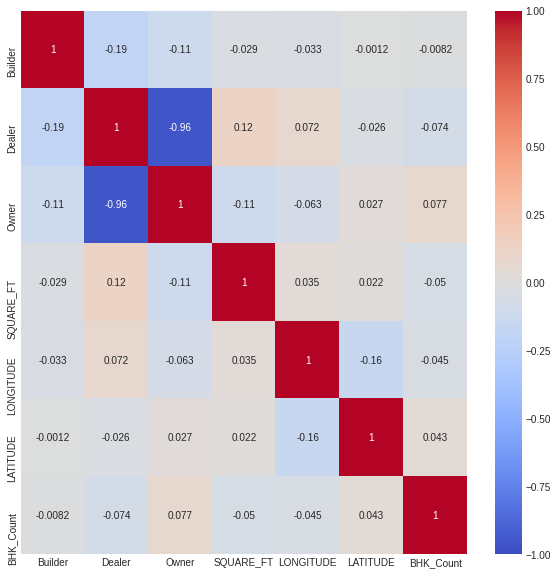

In [ ]:
##correlation matrix. Feature elimination based on multicollinearity
df_corr = trn[num_cols]
corr=df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmin=-1,cmap='coolwarm',annot=True);#,mask=mask);

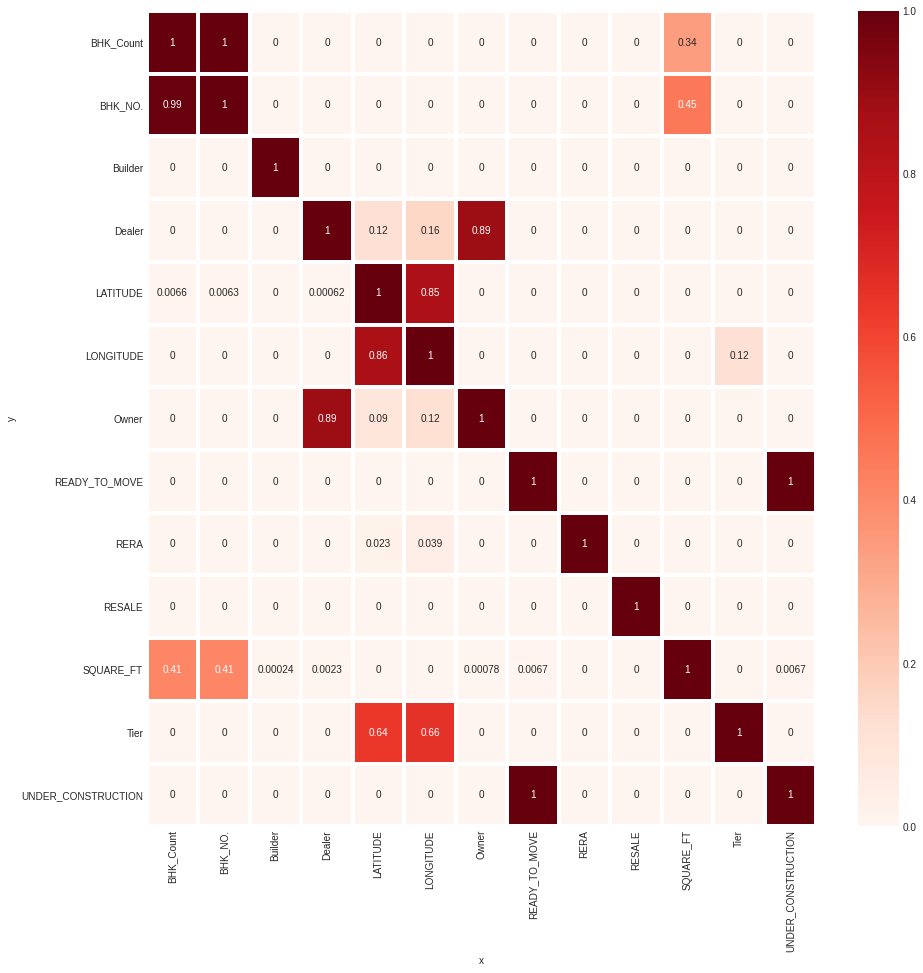

In [ ]:
df=pps.matrix(trn)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig, ax = plt.subplots(figsize=(15,15)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

## Model

In [202]:
from sklearn.model_selection import StratifiedKFold, KFold
from bayes_opt import BayesianOptimization
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error
from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

In [199]:
def RMSLE(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle = make_scorer(RMSLE, greater_is_better=False)

In [231]:
def kfold_cv(trn, target, estimator, n_splits=5):
    featimp_list = []
    add = 0
    splits = n_splits
    target = np.log1p(target)
    kfold, scores = KFold(n_splits=splits,random_state=42), list()
    for train, test in kfold.split(trn,target):
        x_train, x_test = trn.values[train], trn.values[test]
        y_train, y_test = target.values[train], target.values[test]
        model = estimator
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        preds = np.expm1(preds)
        feature_importances = pd.DataFrame(model.feature_importances_,
                                        index = trn.columns,
                                        columns=['importance'])
        featimp_list.append(feature_importances.values)
        score = np.sqrt(mean_squared_log_error(np.expm1(y_test), preds))
        scores.append(score)
        print("Score is", score)

    print("Average:", np.sum(scores)/len(scores))
    for item in featimp_list:
        add+=item
    df_cv=pd.DataFrame(add/len(featimp_list),index=trn.columns,columns=["importance"]).sort_values('importance', ascending=False)
    display(df_cv)
    # df_cv.plot(kind='bar', figsize=(8,10))
    # plt.tight_layout()

### Baseline FeatImp Test

In [ ]:
estimator = LGBMRegressor(n_estimators=2000)
kfold_cv(trn, target, estimator)

### Optimize LGB

In [200]:
#Hyperparameter tuning of LightGBM Regressor using Bayesian optimization

def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, targets):
    estimator = LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves = num_leaves,
        min_child_samples=min_child_samples,
        subsample = subsample,
        random_state = 2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmsle, cv=5)
    return cval.mean()

def optimize_lgb(data, targets):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves = int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators": (1000,4000),
            "num_leaves": (30,120),
            "min_child_samples": (5,50),
            "subsample": (0.3,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [201]:
target_opt = np.log1p(target)
optimize_lgb(trn, target_opt)

|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        | -0.06132  |  13.62    |  2.866e+0 |  69.4     |  0.8498   |
|  2        | -0.06081  |  40.1     |  1.818e+0 |  54.88    |  0.8613   |
|  3        | -0.06234  |  48.12    |  3.628e+0 |  62.2     |  0.6507   |
|  4        | -0.06216  |  35.76    |  3.138e+0 |  63.32    |  0.6928   |
|  5        | -0.06089  |  27.64    |  1.041e+0 |  99.55    |  0.9178   |
|  6        | -0.06081  |  21.42    |  2.846e+0 |  36.78    |  0.5582   |
|  7        | -0.06197  |  46.99    |  2.954e+0 |  65.75    |  0.8521   |
|  8        | -0.06232  |  19.26    |  2.704e+0 |  108.2    |  0.6053   |
|  9        | -0.06119  |  41.1     |  1.431e+0 |  93.38    |  0.7932   |
|  10       | -0.06188  |  14.85    |  3.775e+0 |  69.79    |  0.9365   |
|  11       | -0.06008  |  7.691    |  1.553e+0 |  34.26    |  0.7724   |
|  12       | -0.0607   |  31.76    | 

In [203]:
lgb_optimized_model = LGBMRegressor(min_child_samples=5,
                                    n_estimators=1050,
                                    num_leaves=35,
                                    subsample=0.3342272)

In [209]:
# import joblib
# joblib.dump(lgb_optimized_model,'LGB_OPTMODEL_V1.pkl')

['LGB_OPTMODEL_V1.pkl']

### Optimize CB

In [ ]:
def cb_cv(n_estimators, depth,data, targets):
    estimator = CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        depth=depth,
        random_state = 2,
        verbose = 0,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmsle, cv=5)
    return cval.mean()

def optimize_cb(data, targets):
    def cb_crossval(n_estimators, depth):
        return cb_cv(
            n_estimators=int(n_estimators),
            learning_rate = learning_rate,
            depth = int(depth),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=cb_crossval,
        pbounds={
            "n_estimators": (500, 4000),
            "learning_rate": (0.01,0.05),
            "depth": (4,64),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

### Final Model

In [229]:
def kfold_opt_cv(trn, target, test_set, estimator, n_splits=5):
    featimp_list = []
    add = 0
    splits = n_splits
    target = np.log1p(target)
    oof_pred = oof_preds = np.zeros(len(test_set))
    kfold, scores = KFold(n_splits=splits,random_state=42), list()
    for train, test in kfold.split(trn,target):
        x_train, x_test = trn.values[train], trn.values[test]
        y_train, y_test = target.values[train], target.values[test]
        model = estimator
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        preds = np.expm1(preds)
        oof_pred = model.predict(test_set)
        oof_preds += np.expm1(oof_pred)

        feature_importances = pd.DataFrame(model.feature_importances_,
                                        index = trn.columns,
                                        columns=['importance'])
        featimp_list.append(feature_importances.values)

        score = np.sqrt(mean_squared_log_error(np.expm1(y_test), preds))
        scores.append(score)
        print("Score is", score)

    oof_preds = oof_preds/splits
    print("Average:", np.sum(scores)/len(scores))
    for item in featimp_list:
        add+=item
    df_cv=pd.DataFrame(add/len(featimp_list),index=trn.columns,columns=["importance"]).sort_values('importance', ascending=False)
    display(df_cv)
    return oof_preds

In [220]:
tst.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Builder,Dealer,Owner,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,BHK_Count,Tier,City_freq,Locliaty_freq,Locality_freq
29451,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,6.302933,1,1,21.262000,73.047700,11957,1,1435,13,13
29452,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,2,6.685861,0,0,18.966114,73.148278,44322,0,10040,171,171


In [230]:
lgb_preds = kfold_opt_cv(trn, target, tst, lgb_optimized_model, 10)

Score is 0.2679509292249885
Score is 0.29915196407004685
Score is 0.2879961928952682
Score is 0.2996365827584075
Score is 0.2906445492079197
Score is 0.30923312745696874
Score is 0.29293964979907017
Score is 0.2752825818283848
Score is 0.29806044361209594
Score is 0.31275382535586815
Average: 0.2933649846209018


,importance
SQUARE_FT,9125.0
LONGITUDE,5368.1
LATITUDE,5206.1
Locliaty_freq,5126.2
City_freq,1949.2
BHK_NO.,1150.8
RERA,723.5
Dealer,597.9
BHK_Count,589.9
UNDER_CONSTRUCTION,479.1


## Submission

In [235]:
lgb_preds

array([  11.93013524,   73.75373606,   66.06491727, ..., 9325.15614229,
         84.04167897,  642.97327487])

In [236]:
ss['TARGET(PRICE_IN_LACS)'] = lgb_preds
ss.to_csv('submit_LGB_V1.csv', index=False)